In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ovrlpy

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

Running vertical adjustment
Creating gene expression embeddings for visualization:
Analyzing in 3d mode:
determining pseudocells:
found 11537 pseudocells
sampling expression:


ZEB2: 100%|██████████| 280/280 [03:54<00:00,  1.19it/s]    


Modeling 20 pseudo-celltype clusters;


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Creating signal integrity map:


100%|██████████| 35/35 [02:09<00:00,  3.70s/it]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


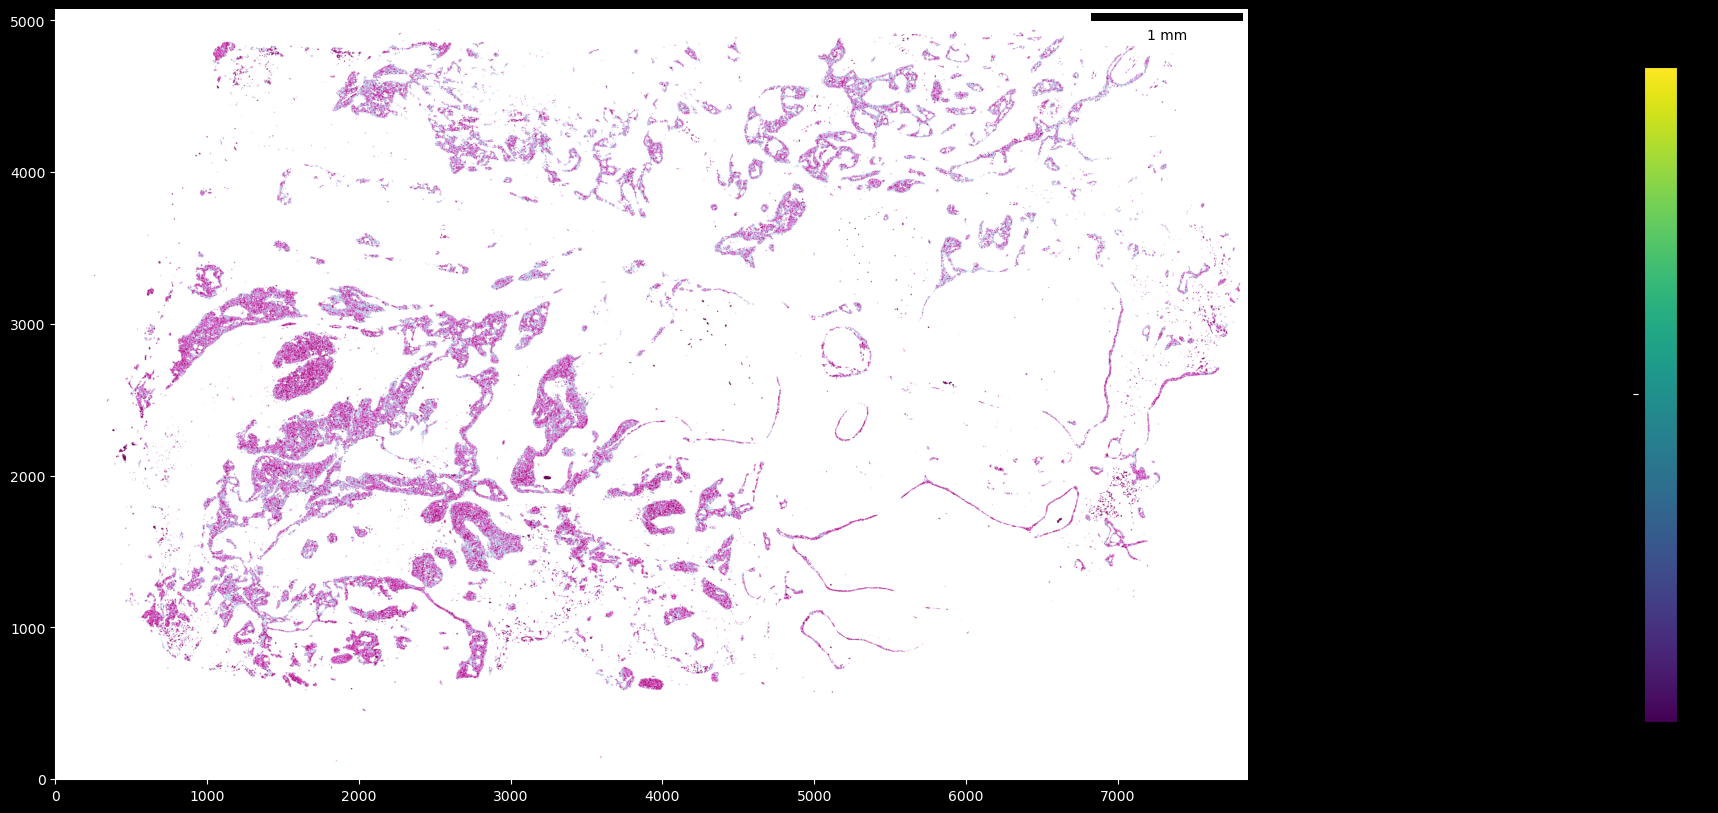

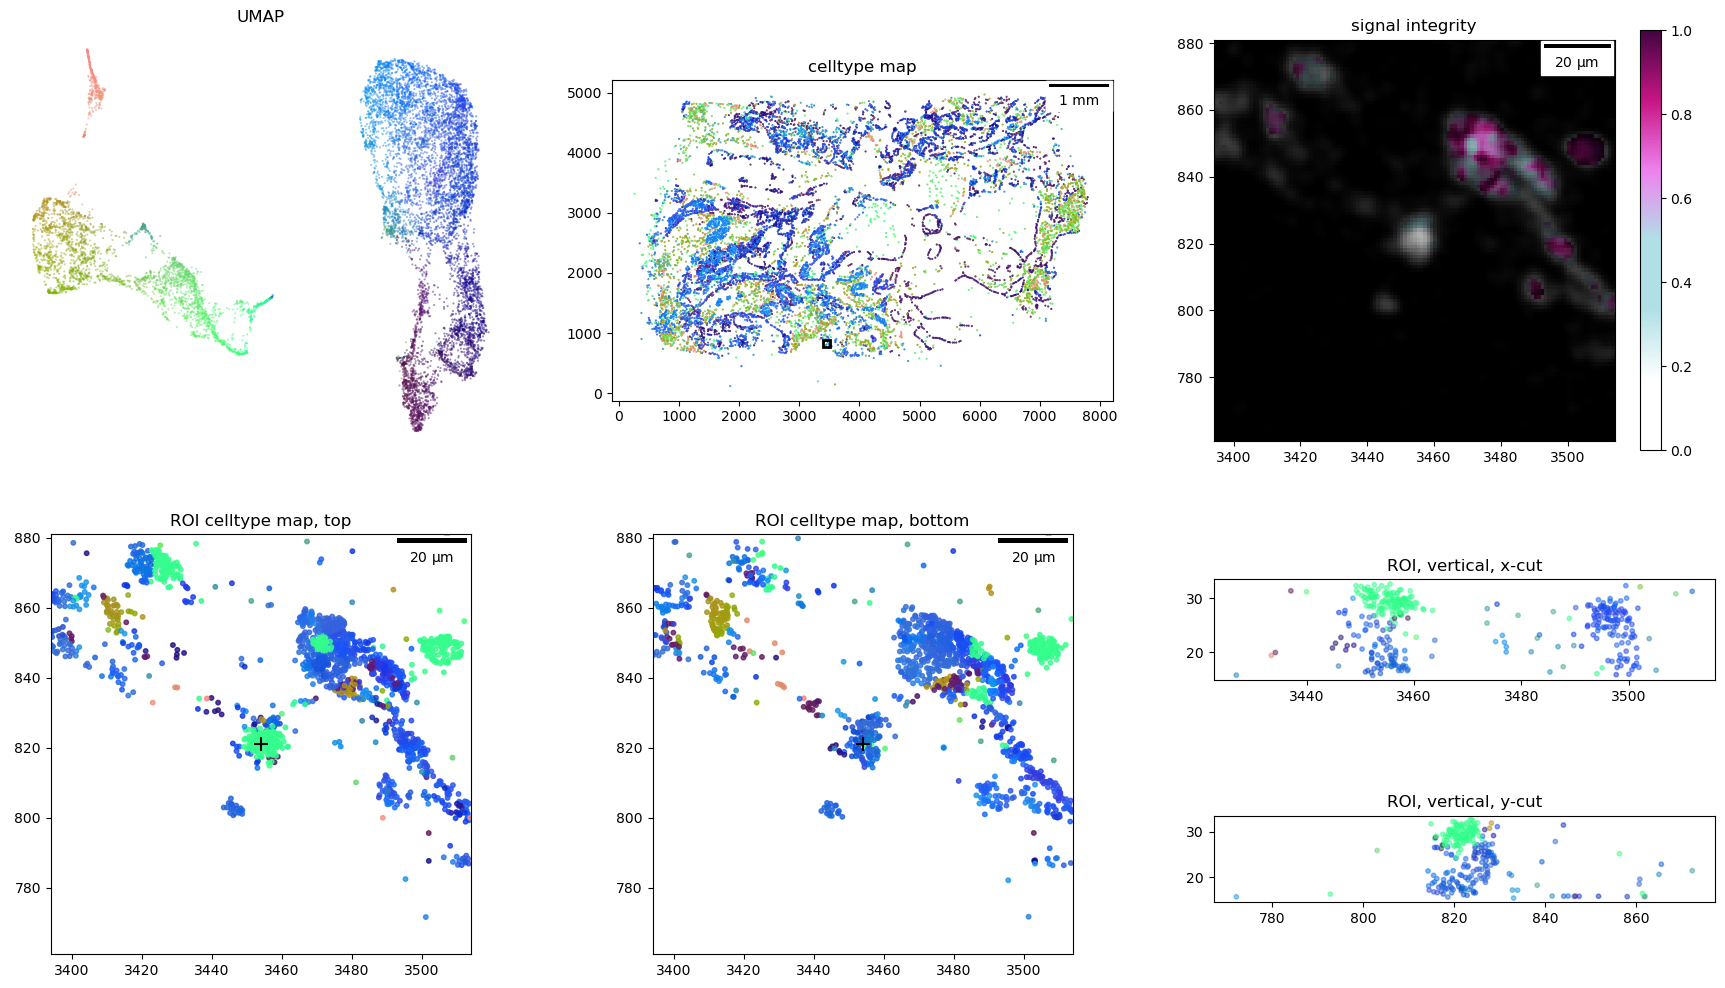

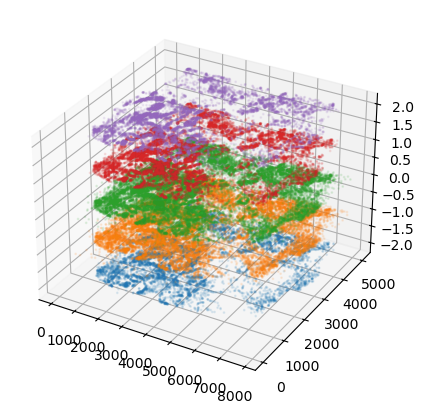

In [2]:
path = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/breast/1256/1256/normalised_results/outs/transcripts.parquet')
coordinate_df = pd.read_parquet(path).query("is_gene & (qv >= 20)") \
    .rename(
        columns={
            "x_location": "x",
            "y_location": "y",
            "z_location": "z",
            "feature_name": "gene",
        }) \
    .query("is_gene & (qv >= 20)")  # remove dummy molecules

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

# coordinate_df[::1000].plot.scatter(x="x", y="y", s=1)
# coordinate_df = coordinate_df.copy()  # make a copy to avoid SettingWithCopyWarning

signal_integrity, signal_strength, visualizer = ovrlpy.run(
    df=coordinate_df, cell_diameter=10, n_expected_celltypes=20
)

fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3
)

doublet_df = ovrlpy.detect_doublets(
    signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
)

_ = plt.scatter(
    doublet_df["x"],
    doublet_df["y"],
    c=doublet_df["integrity"],
    s=1,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
plt.gca().set_aspect("equal")
plt.colorbar()


window_size = 60
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

ovrlpy.plot_region_of_interest(
    x,
    y,
    coordinate_df,
    visualizer,
    signal_integrity,
    signal_strength,
    window_size=window_size,
)


# visualizer.save(result_folder / "Xenium-text-visualizer.vis")

# vis = ovrlpy.load_visualizer(result_folder / "Xenium-text-visualizer.vis")

plt.figure(figsize=(20, 5))

ax = plt.subplot(111, projection="3d")

for i in range(-2, 3):
    subset = coordinate_df[(coordinate_df.z - coordinate_df.z_delim).between(i, i + 1)]

    ax.scatter(
        subset.x[::100],
        subset.y[::100],
        np.zeros(1 + (len(subset) // 100)) + i,
        s=1,
        alpha=0.1,
    )

In [ ]:
def transcripts_to_count_matrix(transcripts,cell_column='cell_id',feature_column='feature_name', qv_treshold=20):
    transcripts = transcripts.query(f"(qv >= {qv_treshold}) & {cell_column} != 'UNASSIGNED'")
    cm = transcripts.pivot_table(index=cell_column, columns=feature_column, aggfunc='size', fill_value=0)
    return cm

integrity_filtering_threshold = 0.5

 # x and y are transposed in ovrlpy output. sanity check x and y must be transposed
assert (coordinate_df.y_pixel.max()+1) == signal_integrity.shape[0]
assert (coordinate_df.x_pixel.max()+1) == signal_integrity.shape[1]

coordinate_df['signal_integrity'] = signal_integrity[coordinate_df.y_pixel,coordinate_df.x_pixel]
coordinate_df['signal_strength'] = signal_strength[coordinate_df.y_pixel,coordinate_df.x_pixel]

coordinate_df_filtered = coordinate_df[coordinate_df.signal_integrity > integrity_filtering_threshold]
cell_mean_integrity = coordinate_df.query("cell_id != 'UNASSIGNED'").groupby('cell_id')['signal_integrity'].mean()
cell_is_singlet = cell_mean_integrity > integrity_filtering_threshold

count_matrix_filtered = transcripts_to_count_matrix(coordinate_df_filtered,feature_column='gene')

/tmp/ipykernel_947089/2333320809.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cm = transcripts.pivot_table(index=cell_column, columns=feature_column, aggfunc='size', fill_value=0)
